### Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

![Process_2](process_2.png)

## 1. Data Exploration/Preparation

In [4]:
spotify_df = pd.read_csv('Spotify_Track_Genre.csv')

In [5]:
spotify_df.head(5)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Note: from the over-view of the code you might notice that there was some additional column similar to row index named as "Unnamed:0" which is unwanted so let's get rid of the that column

In [6]:
spotify_df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)

In [7]:
spotify_df.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [8]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

In [9]:
spotify_df.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [10]:
spotify_df = spotify_df.dropna()

In [11]:
spotify_df.isnull().sum()

track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

### 2. Feature Engineering

#### - Normalize float variables
#### - OHE for Popularity
#### - Create TF-IDF features off of artist genres

In [12]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [13]:
float_cols

array(['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype=object)

In [14]:
ohe_cols = 'popularity'

In [15]:
spotify_df['popularity'].describe()

count    113999.000000
mean         33.238827
std          22.304959
min           0.000000
25%          17.000000
50%          35.000000
75%          50.000000
max         100.000000
Name: popularity, dtype: float64

In [16]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [17]:
spotify_df.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_red
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,14
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,11
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,11
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,14
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,16


In [18]:
# Check for missing values in 'track_genre' column
missing_values = spotify_df['track_genre'].isnull().sum()
print("Missing values in 'track_genre' column:", missing_values)

# Inspect unique values in 'track_genre' column
unique_genres = spotify_df['track_genre'].explode().unique()
print("Unique genres:", unique_genres)
print("Number of unique genres:", len(unique_genres))
print("Data Type in track_genre:", spotify_df['track_genre'].dtype)


Missing values in 'track_genre' column: 0
Unique genres: ['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rocka

In [19]:
# Convert lists of genres to strings for TF-IDF vectorization
spotify_df['track_genre_str'] = spotify_df['track_genre'].apply(lambda x: ' '.join(x))

In [20]:
spotify_df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_red,track_genre_str
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,14,a c o u s t i c
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,11,a c o u s t i c
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,11,a c o u s t i c
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,14,a c o u s t i c
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,16,a c o u s t i c


In [21]:
# Convert lists of genres to strings for TF-IDF vectorization
spotify_df['track_genre_str'] = spotify_df['track_genre'].apply(lambda x: ''.join(x))

In [22]:
print(spotify_df['track_genre_str'].head())

0    acoustic
1    acoustic
2    acoustic
3    acoustic
4    acoustic
Name: track_genre_str, dtype: object


In [23]:
 #simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name):  
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

![TfIdf png](tfidf_4.png)

In [25]:
#function to build entire feature set
def create_feature_set(df, float_cols):
     
    # Process spotify df to create a final set of features that will be used to generate recommendations
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['track_genre_str'])
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe], axis = 1)
     
    #add song id
    final['id']=df['track_id'].values
    
    return final

In [26]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [27]:
complete_feature_set.head()

,genre|acoustic,genre|afrobeat,genre|age,genre|alt,genre|alternative,genre|ambient,genre|and,genre|anime,genre|bass,genre|black,...,pop|12,pop|13,pop|14,pop|15,pop|16,pop|17,pop|18,pop|19,pop|20,id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.15,0.0,0.00,0.0,0.0,0.0,0.0,5SuOikwiRyPMVoIQDJUgSV
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,4qPNDBW1i3p13qLCt0Ki3A
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,1iJBSr7s7jYXzM8EGcbK5b
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.15,0.0,0.00,0.0,0.0,0.0,0.0,6lfxq3CG4xtTiEg7opyCyx
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.15,0.0,0.0,0.0,0.0,5vjLSffimiIP26QG5WcN2K


## 3. Connect to Spotify API

Useful links:
1. https://developer.spotify.com/dashboard/
2. https://spotipy.readthedocs.io/en/2.16.1/

In [98]:
#client id and secret for my application
client_id = '7a832874ab9243239180d6c34dc02f02'
client_secret= '5a95c79436ee4f90a3d73958b19f2de0'

In [99]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [100]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [101]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

In [102]:
sp = spotipy.Spotify(auth=token)

In [103]:
sp.current_user_playlists()

{'href': 'https://api.spotify.com/v1/users/31wwhhgevitsxuew6moremo6fkia/playlists?offset=0&limit=50',
 'items': [{'collaborative': False,
   'description': '',
   'external_urls': {'spotify': 'https://open.spotify.com/playlist/5uG7tystxnVHpySvvK2aYg'},
   'href': 'https://api.spotify.com/v1/playlists/5uG7tystxnVHpySvvK2aYg',
   'id': '5uG7tystxnVHpySvvK2aYg',
   'images': [{'height': 640,
     'url': 'https://i.scdn.co/image/ab67616d0000b273a2fc41b0dd6ce4f0d16a4c46',
     'width': 640}],
   'name': 'Sleep_Time',
   'owner': {'display_name': 'Sumanta Patel',
    'external_urls': {'spotify': 'https://open.spotify.com/user/31wwhhgevitsxuew6moremo6fkia'},
    'href': 'https://api.spotify.com/v1/users/31wwhhgevitsxuew6moremo6fkia',
    'id': '31wwhhgevitsxuew6moremo6fkia',
    'type': 'user',
    'uri': 'spotify:user:31wwhhgevitsxuew6moremo6fkia'},
   'primary_color': None,
   'public': True,
   'snapshot_id': 'NSw2MTZkZWUyMmFkNGY1YTcwMTkwNmRkNzE4Nzk3MzhkZWJhODhlZGFk',
   'tracks': {'href':

In [34]:
id_name = {}
list_photo = {}

for playlist in sp.current_user_playlists()['items']:
    playlist_name = playlist['name']
    playlist_uri = playlist['uri'].split(':')[2]
    
    # Check if images list is not empty before accessing the URL
    if playlist.get('images') and len(playlist['images']) > 0:
        playlist_image_url = playlist['images'][0]['url']
    else:
        # Handle case when images list is empty or doesn't exist
        playlist_image_url = "No Image Available"  # Placeholder or default value
    
    id_name[playlist_name] = playlist_uri
    list_photo[playlist_uri] = playlist_image_url


In [35]:
id_name

{'Sleep_Time': '5uG7tystxnVHpySvvK2aYg',
 'EDM': '5Awp8pMG1Adde6B0PuLJZl',
 'Epic': '74PBiFGMu2f8L6Q3oIw28C',
 '80s_Rock': '0qRCsMTBitoAzoSZSSM1FI'}

In [36]:
playlist_info = id_name

In [37]:

# Assuming you have defined the create_necessary_outputs function
def create_necessary_outputs(playlist_name, id_dic, df):
    playlist = pd.DataFrame()

    for ix, track_info in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        if 'track' in track_info:
            track = track_info['track']
            if 'id' in track and track['id'] in df['track_id'].values:
                playlist.loc[ix, 'artist'] = track['artists'][0]['name']
                playlist.loc[ix, 'name'] = track['name']
                playlist.loc[ix, 'id'] = track['id']

                if 'album' in track and 'images' in track['album'] and len(track['album']['images']) > 1:
                    playlist.loc[ix, 'url'] = track['album']['images'][1]['url']

                if 'added_at' in track_info:
                    playlist.loc[ix, 'date_added'] = track_info['added_at']

    playlist['date_added'] = pd.to_datetime(playlist.get('date_added'))  # Convert to datetime if present
    #playlist = playlist.dropna(subset=['id'])  # Drop rows with NaN values in 'id'
    
    return playlist



In [38]:
# Iterate through playlist_info dictionary and process each playlist
playlist_data = {}
for playlist_name, playlist_id in playlist_info.items():
    playlist_data[playlist_name] = create_necessary_outputs(playlist_name, playlist_info, spotify_df)

In [39]:
playlist_data['80s_Rock']

,artist,name,id,url,date_added
1,Guns N' Roses,Sweet Child O' Mine,7snQQk1zcKl8gZ92AnueZW,https://i.scdn.co/image/ab67616d00001e0221ebf4...,2023-12-23 16:22:12+00:00
4,Bon Jovi,You Give Love A Bad Name,0rmGAIH9LNJewFw7nKzZnc,https://i.scdn.co/image/ab67616d00001e021336b3...,2023-12-23 16:24:07+00:00
6,Scorpions,Rock You Like a Hurricane - 2011,46QazXxQS0B31CnbRCy8CV,https://i.scdn.co/image/ab67616d00001e029f2023...,2023-12-23 16:26:12+00:00
7,Bryan Adams,Summer Of '69,0GONea6G2XdnHWjNZd6zt3,https://i.scdn.co/image/ab67616d00001e02cf1fee...,2023-12-23 16:26:39+00:00


In [40]:
playlist_data['Sleep_Time']

,artist,name,id,url,date_added
0,Wham!,Wake Me Up Before You Go-Go,0ikz6tENMONtK6qGkOrU3c,https://i.scdn.co/image/ab67616d00001e02a2fc41...,2023-12-23 16:30:03+00:00
2,Aerosmith,"I Don't Want to Miss a Thing - From ""Armageddo...",225xvV8r1yKMHErSWivnow,https://i.scdn.co/image/ab67616d00001e02da8d92...,2023-12-23 16:31:12+00:00


In [41]:
playlist_any= create_necessary_outputs('Sleep_Time', id_name,spotify_df)
playlist_any

,artist,name,id,url,date_added
0,Wham!,Wake Me Up Before You Go-Go,0ikz6tENMONtK6qGkOrU3c,https://i.scdn.co/image/ab67616d00001e02a2fc41...,2023-12-23 16:30:03+00:00
2,Aerosmith,"I Don't Want to Miss a Thing - From ""Armageddo...",225xvV8r1yKMHErSWivnow,https://i.scdn.co/image/ab67616d00001e02da8d92...,2023-12-23 16:31:12+00:00


In [64]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df,pname):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df[pname]['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) // columns + 1, columns, i + 1)  # Use // for integer division

        try:
            image = io.imread(url)
            plt.imshow(image)
            plt.xticks(color='w', fontsize=0.1)
            plt.yticks(color='w', fontsize=0.1)
            plt.xlabel(df['name'].values[i], fontsize=12)
            plt.tight_layout(h_pad=0.4, w_pad=0)
            plt.subplots_adjust(wspace=None, hspace=None)
        except Exception as e:
            print(f"Unable to load image {url}: {e}")
            plt.text(0.5, 0.5, "Image not available", horizontalalignment='center', 
                     verticalalignment='center', transform=plt.gca().transAxes)
            plt.axis('off')  # Hide axis for cases where image cannot be loaded

    plt.show()


Unable to load image https://i.scdn.co/image/ab67616d00001e0221ebf49b3292c3f0f575f0f5: 'name'
Unable to load image https://i.scdn.co/image/ab67616d00001e021336b31b6a1799f0de5807ac: 'name'
Unable to load image https://i.scdn.co/image/ab67616d00001e029f2023d391c3bd4acf4d51c6: 'name'
Unable to load image https://i.scdn.co/image/ab67616d00001e02cf1fee2a55e98e22bf358512: 'name'


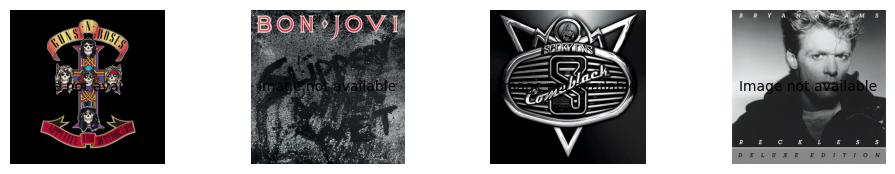

In [65]:
pname = '80s_Rock'
visualize_songs(playlist_data,pname)

## 4. Create Playlist Vector

![Summary](summarization_2.png)

In [66]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [68]:
pname = '80s_Rock'
playlist_data[pname]
playlist_any = playlist_data[pname]
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_any, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [69]:
complete_feature_set_playlist_vector_EDM.shape

(144,)

## 5. Generate Recommendations

![Cosine img](cosine_sim_2.png)

In [106]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['track_id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['track_id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [107]:
edm_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [111]:
edm_top40['track_name']

71222                        Can't Stop
71750                                 嘘
71609                   Smooth Criminal
71482           The Kids Aren't Alright
71724                         Paralyzer
71377          You're Gonna Go Far, Kid
71586           We're Not Gonna Take It
71700                           乱舞のメロディ
71208                       Last Resort
71583                          Roulette
71159                           Monster
71055                      It's My Life
71254                         the WORLD
71106                   Battle Symphony
71904                          Soldiers
71768                     Hit the Floor
71169                          Papercut
71896                        Set It Off
71888                        Set It Off
71359                           Du hast
71310                          B.Y.O.B.
71473                        Don't Stay
71818                        The Anthem
71004               Sweet Child O' Mine
71584                         Afterlife
